# Create animals list

In [ ]:
import os, re

animals = []

file_path = os.path.join('..', 'Dataset', 'artefact1', 'classes.txt')
if os.path.exists(file_path):
    data = open(file_path, "r")
    for i in data:
        if len(re.findall("[a-zA-Z]+", i)) > 1:
            animals.extend(re.findall("[a-zA-Z]+", i))
            animals.append(re.findall("[a-zA-Z]+", i)[0] + ' ' + re.findall("[a-zA-Z]+", i)[1])
            animals.append(re.findall("[a-zA-Z]+", i)[0] + '_' + re.findall("[a-zA-Z]+", i)[1])
        else:
            animals.append(re.findall("[a-zA-Z]+", i)[0])
            
more_animals = ['african_buffalo', 'alligator', 'amphibian', 'amur_leopard', 'ants', 'bear', 
                'blue_whale', 'bobcat', 'bull', 'cat', 'chimp', 'chimpanzee', 'cow', 'dog', 
                'dolphin', 'water_buffalo', 'elephant', 'frog', 'giant', 'giant_panda', 
                'goat', 'gorilla', 'horse', 'killer_whale', 'lion', 'lizard', 'monkey', 
                'mouse', 'orangutan', 'ox', 'panda', 'polar_bear', 'rabbit', 'rat', 'rhino', 
                'rhinoceros', 'seal', 'siamese_cat', 'skunk', 'spider_monkey', 'squirrel', 
                'tiger', 'turtle', 'walrus', 'whale']
for i in more_animals:
    if len(re.findall("[a-zA-Z]+", i)) > 1:
        if re.findall("[a-zA-Z]+", i)[0] not in animals:
            animals.append(re.findall("[a-zA-Z]+", i)[0])
            if re.findall("[a-zA-Z]+", i)[1] not in animals:
                animals.append(re.findall("[a-zA-Z]+", i)[1])
                if re.findall("[a-zA-Z]+", i)[0] + '_' + re.findall("[a-zA-Z]+", i)[1] not in animals:
                    animals.append(re.findall("[a-zA-Z]+", i)[0] + ' ' + re.findall("[a-zA-Z]+", i)[1])
                    animals.append(re.findall("[a-zA-Z]+", i)[0] + '_' + re.findall("[a-zA-Z]+", i)[1])
    else:
        if re.findall("[a-zA-Z]+", i)[0] not in animals:
            animals.append(re.findall("[a-zA-Z]+", i)[0])

file_path = os.path.join('..', 'Dataset', 'artefact1', 'animals.txt')
f = open(file_path, "a")
for i in animals:
    f.write(i)
    f.write('\n')
f.close()

# Autoencoder

In [1]:
import numpy as np
import urllib.request
from gensim.utils import simple_preprocess
import os, re

# Download GloVe embeddings
# glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
# urllib.request.urlretrieve(glove_url, "glove.6B.zip")

# import zipfile
# with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
#     zip_ref.extractall("glove.6B")

In [8]:
# Example custom dataset
# custom_sentences = [
#     'african_buffalo', 'alligator', 'amphibian', 'amur_leopard', 
#     'ants', 'bear', 'bird', 'blue_whale', 'bobcat', 'cat', 'chimp', 
#     'chimpanzee', 'cow', 'dog', 'dolphin', 'domestic_water_buffalo', 
#     'eagle', 'elephant', 'fish', 'frog', 'giant', 'giant_panda', 'goat', 
#     'gorilla', 'hen', 'horse', 'killer_whale', 'lion', 'lizard', 'monkey', 
#     'mouse', 'orangutan', 'ostrich', 'ox', 'panda', 'polar_bear', 'rabbit', 
#     'rat', 'rhino', 'rhinoceros', 'rhinoceroses', 'seal', 'sealskin', 
#     'siamese_cat', 'skunk', 'spider_monkey', 'squirrel', 'tiger', 'turtle', 
#     'walrus', 'whale', 'bird', 'fish', 'lion', 'tiger', 'bull'
# ]
animals_list_file_path = os.path.join('..', 'Dataset', 'artefact1', 'animals.txt')
with open(animals_list_file_path, "r") as f:
    custom_sentences = [line[:-1] for line in f]

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = load_glove_embeddings("glove.6B/glove.6B.300d.txt")  # Using 50d GloVe embeddings
print(f"embeddings_index : {type(embeddings_index)} \n")

# Convert sentences to embeddings
def sentence_to_embedding(sentence, embeddings_index):
    words = simple_preprocess(sentence)
    valid_words = [embeddings_index[word] for word in words if word in embeddings_index]
    if valid_words:
        return np.mean(valid_words, axis=0)
    else:
        return np.zeros(300) # Using 50d GloVe embeddings

sentence_embeddings = np.array([sentence_to_embedding(sentence, embeddings_index) for sentence in custom_sentences])
print(f"sentence_embeddings : {type(sentence_embeddings)} \n")

embeddings_index : <class 'dict'> 

sentence_embeddings : <class 'numpy.ndarray'> 



In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the size of the input and latent space
input_dim = 300 # 50  # Dimension of GloVe embeddings
latent_dim = 16  # Dimension of latent space

# Input layer
input_layer = Input(shape=(input_dim,))

# Sample Test 1
# # Encoder layers
# encoded = Dense(32, activation='relu')(input_layer)
# encoded = Dense(latent_dim, activation='relu')(encoded)

# # Decoder layers
# decoded = Dense(32, activation='relu')(encoded)
# decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Sample Test 2
# Encoder layers
encoded = Dense(latent_dim * 4, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(latent_dim * 2, activation='relu')(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(latent_dim, activation='relu')(encoded)

# Decoder layers
decoded = Dense(latent_dim * 2, activation='relu')(encoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(latent_dim * 4, activation='relu')(decoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# # Sample Test 3
# # Encoder layers
# encoded = Dense(latent_dim * 4, activation='relu')(input_layer)
# encoded = Dense(latent_dim * 2, activation='relu')(encoded)
# encoded = Dense(latent_dim, activation='relu')(encoded)

# # Decoder layers
# decoded = Dense(latent_dim * 2, activation='relu')(encoded)
# decoded = Dense(latent_dim * 4, activation='relu')(decoded)
# decoded = Dense(input_dim, activation='sigmoid')(decoded)

# # Sample Test 4
# # Encoder layers
# encoded = Dense(latent_dim * 16, activation='relu')(input_layer)
# encoded = Dense(latent_dim * 8, activation='relu')(encoded)
# encoded = Dense(latent_dim * 4, activation='relu')(encoded)
# encoded = Dense(latent_dim * 2, activation='relu')(encoded)
# encoded = Dense(latent_dim, activation='relu')(encoded)

# # Decoder layers
# decoded = Dense(latent_dim * 2, activation='relu')(encoded)
# decoded = Dense(latent_dim * 4, activation='relu')(decoded)
# decoded = Dense(latent_dim * 8, activation='relu')(decoded)
# decoded = Dense(latent_dim * 16, activation='relu')(decoded)
# decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)

# Encoder model
encoder = Model(input_layer, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
# autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [10]:
encoder.summary() 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense_10 (Dense)            (None, 64)                19264     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
Total params: 21872 (85.44 KB)
Trainable params: 21872 (85.

In [11]:
autoencoder.summary() 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense_10 (Dense)            (None, 64)                19264     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 32)                544 

In [12]:
# Train the autoencoder
autoencoder.fit(sentence_embeddings, sentence_embeddings, epochs=500, batch_size=32, shuffle=True, validation_split=0.1)

Epoch 1/500
3/3 [==============================] - 3s 158ms/step - loss: 0.3764 - val_loss: 0.4040
Epoch 2/500
3/3 [==============================] - 0s 29ms/step - loss: 0.3727 - val_loss: 0.3994
Epoch 3/500
3/3 [==============================] - 0s 33ms/step - loss: 0.3667 - val_loss: 0.3909
Epoch 4/500
3/3 [==============================] - 0s 32ms/step - loss: 0.3568 - val_loss: 0.3761
Epoch 5/500
3/3 [==============================] - 0s 31ms/step - loss: 0.3404 - val_loss: 0.3522
Epoch 6/500
3/3 [==============================] - 0s 46ms/step - loss: 0.3182 - val_loss: 0.3181
Epoch 7/500
3/3 [==============================] - 0s 33ms/step - loss: 0.2871 - val_loss: 0.2745
Epoch 8/500
3/3 [==============================] - 0s 31ms/step - loss: 0.2523 - val_loss: 0.2283
Epoch 9/500
3/3 [==============================] - 0s 45ms/step - loss: 0.2140 - val_loss: 0.1894
Epoch 10/500
3/3 [==============================] - 0s 40ms/step - loss: 0.1871 - val_loss: 0.1640
Epoch 11/500
3/3 [

Epoch 84/500
3/3 [==============================] - 0s 31ms/step - loss: 0.1236 - val_loss: 0.1440
Epoch 85/500
3/3 [==============================] - 0s 35ms/step - loss: 0.1243 - val_loss: 0.1438
Epoch 86/500
3/3 [==============================] - 0s 51ms/step - loss: 0.1239 - val_loss: 0.1437
Epoch 87/500
3/3 [==============================] - 0s 52ms/step - loss: 0.1238 - val_loss: 0.1436
Epoch 88/500
3/3 [==============================] - 0s 53ms/step - loss: 0.1239 - val_loss: 0.1435
Epoch 89/500
3/3 [==============================] - 0s 42ms/step - loss: 0.1239 - val_loss: 0.1435
Epoch 90/500
3/3 [==============================] - 0s 33ms/step - loss: 0.1236 - val_loss: 0.1434
Epoch 91/500
3/3 [==============================] - 0s 32ms/step - loss: 0.1237 - val_loss: 0.1434
Epoch 92/500
3/3 [==============================] - 0s 29ms/step - loss: 0.1235 - val_loss: 0.1433
Epoch 93/500
3/3 [==============================] - 0s 33ms/step - loss: 0.1235 - val_loss: 0.1433
Epoch 94/5

3/3 [==============================] - 0s 31ms/step - loss: 0.1147 - val_loss: 0.1351
Epoch 167/500
3/3 [==============================] - 0s 30ms/step - loss: 0.1146 - val_loss: 0.1351
Epoch 168/500
3/3 [==============================] - 0s 31ms/step - loss: 0.1145 - val_loss: 0.1352
Epoch 169/500
3/3 [==============================] - 0s 33ms/step - loss: 0.1143 - val_loss: 0.1353
Epoch 170/500
3/3 [==============================] - 0s 62ms/step - loss: 0.1141 - val_loss: 0.1352
Epoch 171/500
3/3 [==============================] - 0s 39ms/step - loss: 0.1143 - val_loss: 0.1351
Epoch 172/500
3/3 [==============================] - 0s 32ms/step - loss: 0.1144 - val_loss: 0.1351
Epoch 173/500
3/3 [==============================] - 0s 40ms/step - loss: 0.1144 - val_loss: 0.1351
Epoch 174/500
3/3 [==============================] - 0s 39ms/step - loss: 0.1140 - val_loss: 0.1352
Epoch 175/500
3/3 [==============================] - 0s 39ms/step - loss: 0.1141 - val_loss: 0.1353
Epoch 176/500


3/3 [==============================] - 0s 35ms/step - loss: 0.1087 - val_loss: 0.1328
Epoch 249/500
3/3 [==============================] - 0s 39ms/step - loss: 0.1092 - val_loss: 0.1329
Epoch 250/500
3/3 [==============================] - 0s 33ms/step - loss: 0.1090 - val_loss: 0.1331
Epoch 251/500
3/3 [==============================] - 0s 33ms/step - loss: 0.1089 - val_loss: 0.1332
Epoch 252/500
3/3 [==============================] - 0s 60ms/step - loss: 0.1088 - val_loss: 0.1332
Epoch 253/500
3/3 [==============================] - 0s 43ms/step - loss: 0.1086 - val_loss: 0.1332
Epoch 254/500
3/3 [==============================] - 0s 42ms/step - loss: 0.1091 - val_loss: 0.1331
Epoch 255/500
3/3 [==============================] - 0s 45ms/step - loss: 0.1085 - val_loss: 0.1329
Epoch 256/500
3/3 [==============================] - 0s 44ms/step - loss: 0.1087 - val_loss: 0.1327
Epoch 257/500
3/3 [==============================] - 0s 32ms/step - loss: 0.1089 - val_loss: 0.1325
Epoch 258/500


3/3 [==============================] - 0s 31ms/step - loss: 0.1058 - val_loss: 0.1317
Epoch 331/500
3/3 [==============================] - 0s 29ms/step - loss: 0.1059 - val_loss: 0.1317
Epoch 332/500
3/3 [==============================] - 0s 34ms/step - loss: 0.1061 - val_loss: 0.1317
Epoch 333/500
3/3 [==============================] - 0s 32ms/step - loss: 0.1057 - val_loss: 0.1317
Epoch 334/500
3/3 [==============================] - 0s 38ms/step - loss: 0.1056 - val_loss: 0.1317
Epoch 335/500
3/3 [==============================] - 0s 44ms/step - loss: 0.1068 - val_loss: 0.1316
Epoch 336/500
3/3 [==============================] - 0s 43ms/step - loss: 0.1053 - val_loss: 0.1315
Epoch 337/500
3/3 [==============================] - 0s 41ms/step - loss: 0.1065 - val_loss: 0.1315
Epoch 338/500
3/3 [==============================] - 0s 42ms/step - loss: 0.1055 - val_loss: 0.1315
Epoch 339/500
3/3 [==============================] - 0s 41ms/step - loss: 0.1056 - val_loss: 0.1316
Epoch 340/500


3/3 [==============================] - 0s 26ms/step - loss: 0.1037 - val_loss: 0.1307
Epoch 413/500
3/3 [==============================] - 0s 29ms/step - loss: 0.1043 - val_loss: 0.1307
Epoch 414/500
3/3 [==============================] - 0s 31ms/step - loss: 0.1039 - val_loss: 0.1307
Epoch 415/500
3/3 [==============================] - 0s 30ms/step - loss: 0.1039 - val_loss: 0.1308
Epoch 416/500
3/3 [==============================] - 0s 26ms/step - loss: 0.1046 - val_loss: 0.1308
Epoch 417/500
3/3 [==============================] - 0s 24ms/step - loss: 0.1046 - val_loss: 0.1308
Epoch 418/500
3/3 [==============================] - 0s 30ms/step - loss: 0.1044 - val_loss: 0.1308
Epoch 419/500
3/3 [==============================] - 0s 31ms/step - loss: 0.1048 - val_loss: 0.1307
Epoch 420/500
3/3 [==============================] - 0s 28ms/step - loss: 0.1038 - val_loss: 0.1308
Epoch 421/500
3/3 [==============================] - 0s 31ms/step - loss: 0.1039 - val_loss: 0.1308
Epoch 422/500


3/3 [==============================] - 0s 32ms/step - loss: 0.1021 - val_loss: 0.1299
Epoch 495/500
3/3 [==============================] - 0s 33ms/step - loss: 0.1021 - val_loss: 0.1299
Epoch 496/500
3/3 [==============================] - 0s 32ms/step - loss: 0.1030 - val_loss: 0.1300
Epoch 497/500
3/3 [==============================] - 0s 33ms/step - loss: 0.1022 - val_loss: 0.1301
Epoch 498/500
3/3 [==============================] - 0s 32ms/step - loss: 0.1029 - val_loss: 0.1300
Epoch 499/500
3/3 [==============================] - 0s 27ms/step - loss: 0.1015 - val_loss: 0.1301
Epoch 500/500
3/3 [==============================] - 0s 29ms/step - loss: 0.1019 - val_loss: 0.1301


##### test 1 result : loss: 0.1155 - val_loss: 0.1362

##### test 2 result : loss: 0.1223 - val_loss: 0.1427

##### test 3 result : loss: 0.1202 - val_loss: 0.1416

##### test 4 result : loss: 0.1222 - val_loss: 0.1441

##### test 5 result : loss: 0.1019 - val_loss: 0.1301

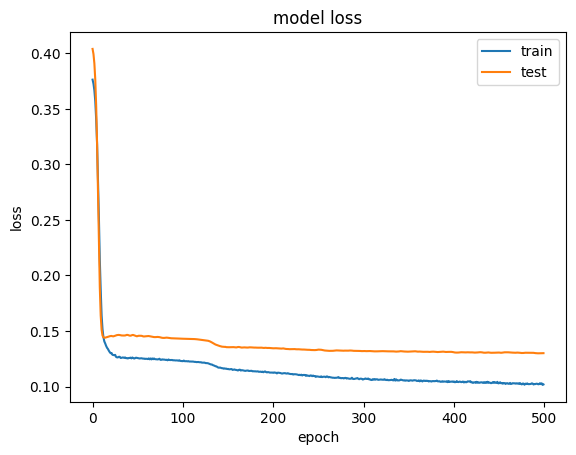

In [13]:
import matplotlib.pyplot as plt

image_name = 'test_4_result.png'
image_folder_path = os.path.join('..', 'Dataset', 'artefact1', 'result_images')
image_path = os.path.join(image_folder_path, image_name)

# summarize history for loss
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(image_path, bbox_inches='tight')
plt.show()

In [73]:
custom_sentences.index('cat')

12

In [14]:
# Encode sentences to get their latent representations
sentence_latents = encoder.predict(sentence_embeddings)
# print(f"sentence_latents : {sentence_latents}")

# Create a dictionary to map sentences to their latent representations
sentence_to_latent = {i: sentence_latents[i] for i in range(len(custom_sentences))}
# print(f"sentence_to_latent : {sentence_to_latent}")

3/3 [==============================] - 0s 10ms/step


In [15]:
print(custom_sentences, '\n')
print(sentence_to_latent[12], custom_sentences[12])

['antelope', 'grizzly', 'bear', 'grizzly bear', 'grizzly_bear', 'killer', 'whale', 'killer whale', 'killer_whale', 'beaver', 'dalmatian', 'persian', 'cat', 'persian cat', 'persian_cat', 'horse', 'german', 'shepherd', 'german shepherd', 'german_shepherd', 'blue', 'whale', 'blue whale', 'blue_whale', 'siamese', 'cat', 'siamese cat', 'siamese_cat', 'skunk', 'mole', 'tiger', 'hippopotamus', 'leopard', 'moose', 'spider', 'monkey', 'spider monkey', 'spider_monkey', 'humpback', 'whale', 'humpback whale', 'humpback_whale', 'elephant', 'gorilla', 'ox', 'fox', 'sheep', 'seal', 'chimpanzee', 'hamster', 'squirrel', 'rhinoceros', 'rabbit', 'bat', 'giraffe', 'wolf', 'chihuahua', 'rat', 'weasel', 'otter', 'buffalo', 'zebra', 'giant', 'panda', 'giant panda', 'giant_panda', 'deer', 'bobcat', 'pig', 'lion', 'mouse', 'polar', 'bear', 'polar bear', 'polar_bear', 'collie', 'walrus', 'raccoon', 'cow', 'dolphin', 'african', 'alligator', 'amphibian', 'amur', 'ants', 'bull', 'chimp', 'dog', 'water', 'frog', 'g

In [16]:
from scipy.spatial.distance import cosine

def find_similar_sentences(target_sentence_index, sentence_to_latent, top_n=10):
    target_latent = sentence_to_latent[target_sentence_index]
    similarities = []
    for index, latent in sentence_to_latent.items():
        if index != target_sentence_index:
            similarity = 1 - cosine(target_latent, latent)
            similarities.append((index, similarity))
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Find sentences similar to the first sentence
similar_sentences = find_similar_sentences(12, sentence_to_latent, top_n=10)
print("Most similar sentences to the first sentence:")
for index, score in similar_sentences:
    print(f"Sentence: {custom_sentences[index]} - Similarity: {score}")


Most similar sentences to the first sentence:
Sentence: cat - Similarity: 1
Sentence: persian cat - Similarity: 0.9717339277267456
Sentence: dog - Similarity: 0.9150887727737427
Sentence: mouse - Similarity: 0.911148190498352
Sentence: siamese cat - Similarity: 0.8946542143821716
Sentence: pig - Similarity: 0.8934038281440735
Sentence: horse - Similarity: 0.8895567655563354
Sentence: rabbit - Similarity: 0.8887732625007629
Sentence: hamster - Similarity: 0.8573532700538635
Sentence: persian - Similarity: 0.8536462187767029


#### test 1 result

Most similar sentences to the first sentence:

Sentence: cat - Similarity: 1

Sentence: dog - Similarity: 0.9870926737785339

Sentence: giant - Similarity: 0.9861204028129578

Sentence: cow - Similarity: 0.9859968423843384

Sentence: siamese cat - Similarity: 0.9847277998924255

Sentence: persian cat - Similarity: 0.9824627041816711

Sentence: giant panda - Similarity: 0.9820453524589539

Sentence: rat - Similarity: 0.9744608402252197

Sentence: rabbit - Similarity: 0.9692093133926392

Sentence: leopard - Similarity: 0.9681882262229919

#### test 2 result

Most similar sentences to the first sentence:

Sentence: cat - Similarity: 1

Sentence: rabbit - Similarity: 0.9987221360206604

Sentence: siamese cat - Similarity: 0.9984137415885925

Sentence: elephant - Similarity: 0.997565746307373

Sentence: cow - Similarity: 0.997138261795044

Sentence: lizard - Similarity: 0.9970594048500061

Sentence: sheep - Similarity: 0.9967566132545471

Sentence: goat - Similarity: 0.9963944554328918

Sentence: turtle - Similarity: 0.9963575601577759

Sentence: zebra - Similarity: 0.9961840510368347

#### test 3 result

Most similar sentences to the first sentence:

Sentence: cat - Similarity: 1

Sentence: spider monkey - Similarity: 0.9993979334831238

Sentence: monkey - Similarity: 0.9989051818847656

Sentence: chimpanzee - Similarity: 0.9987993836402893

Sentence: dog - Similarity: 0.9985986948013306

Sentence: zebra - Similarity: 0.9984158873558044

Sentence: goat - Similarity: 0.9976542592048645

Sentence: spider - Similarity: 0.9976372718811035

Sentence: panda - Similarity: 0.9974632859230042

Sentence: rhino - Similarity: 0.9974162578582764

#### test 4 result

Most similar sentences to the first sentence:

Sentence: cat - Similarity: 1

Sentence: siamese cat - Similarity: 0.9999932646751404

Sentence: leopard - Similarity: 0.9999926686286926

Sentence: raccoon - Similarity: 0.9999924302101135

Sentence: rat - Similarity: 0.999991774559021

Sentence: alligator - Similarity: 0.9999889731407166

Sentence: bull - Similarity: 0.9999883770942688

Sentence: grizzly - Similarity: 0.9999867677688599

Sentence: dog - Similarity: 0.9999856948852539

Sentence: otter - Similarity: 0.9999852180480957

#### test 5 result

Most similar sentences to the first sentence:

Sentence: cat - Similarity: 1

Sentence: persian cat - Similarity: 0.9717339277267456

Sentence: dog - Similarity: 0.9150887727737427

Sentence: mouse - Similarity: 0.911148190498352

Sentence: siamese cat - Similarity: 0.8946542143821716

Sentence: pig - Similarity: 0.8934038281440735

Sentence: horse - Similarity: 0.8895567655563354

Sentence: rabbit - Similarity: 0.8887732625007629

Sentence: hamster - Similarity: 0.8573532700538635

Sentence: persian - Similarity: 0.8536462187767029

### Save model

In [17]:
model_folder_path = os.path.join('..', 'Dataset', 'artefact1', 'model')

encoder.save(os.path.join(model_folder_path, 'encoder_model.h5'))
autoencoder.save(os.path.join(model_folder_path, 'autoencoder_model.h5'))

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# ResNet50_GLCM

### ResNet50

ResNet50, short for "Residual Network 50," is a deep convolutional neural network architecture developed by Kaiming He and his colleagues at Microsoft Research, which won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2015. The key innovation of ResNet is the introduction of residual blocks, which help in training very deep networks by addressing the vanishing gradient problem.

### Applications of ResNet50

ResNet50 and its variants have been widely adopted in various computer vision tasks such as image classification, object detection, and segmentation due to their effectiveness in training deep networks without suffering from vanishing gradients. They are also commonly used as a backbone in many state-of-the-art models and frameworks.

### GLCM

GLCM, or the Gray-Level Co-Occurrence Matrix, is a statistical method used in image processing to analyze the texture of an image. It is particularly useful in extracting second-order statistical texture features from an image. The GLCM describes how often pairs of pixel with specific values and in a specified spatial relationship occur in an image.

### Key Concepts of GLCM

1. Gray Levels: The intensity values of the pixels in an image.
2. Spatial Relationship: The relative position of one pixel to another, typically defined by an offset (distance and direction). Common offsets include horizontal, vertical, and diagonal neighbors.
2. Matrix Construction: For a given offset, the GLCM is constructed by counting how often a pixel with value `𝑖` is adjacent to a pixel with value `𝑗`.

### Texture Features Derived from GLCM

Several texture features can be derived from the GLCM, including:

1. Energy: Measures the uniformity of the texture. High energy indicates fewer repeated pairs.
2. Correlation: Measures the linear dependency of gray levels on those of neighboring pixels.
3. Dissimilarity: Measures the variation in gray levels.
4. Homogeneity: Measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal.
5. Contrast: Measures the local variations in the GLCM.

### Other Methods for Second-Order Statistical Texture Features

Besides GLCM, there are other methods for extracting second-order statistical texture features:

1. Gray-Level Run Length Matrix (GLRLM): Measures the length of consecutive pixels with the same gray level value.
2. Gray-Level Size Zone Matrix (GLSZM): Measures the size of connected regions of pixels with the same gray level.
3. Neighborhood Gray-Tone Difference Matrix (NGTDM): Measures the difference between a pixel and the average gray level of its neighborhood.


# Create and Save CSV

In [18]:
# libs
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from PIL import Image
import ast

import tensorflow as tf

from keras.applications import ResNet50

from skimage.feature import greycomatrix, greycoprops

import warnings
warnings.filterwarnings('ignore')

In [19]:
# function
# Function to extract visual features using ResNet50
def extract_visual_features(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize image for ResNet50 input
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    visual_features = model.predict(img_array, verbose = 0)

    return visual_features

# Function to compute GLCM texture features
def compute_texture_features(image_path):
    # Define your GLCM properties (distances and angles)
    distances = [1, 3, 5, 3, 1, 3, 5]
    angles = [0, 0, 0, np.pi/4, np.pi/2, np.pi/2, np.pi/2]
    
    glcm_features = []
    for distance, angle in zip(distances, angles):
        img_gray = Image.open(image_path).convert('L')  # Convert image to grayscale
        img_gray_array = np.array(img_gray)

        # Compute GLCM properties
        glcm = greycomatrix(img_gray_array, distances=[distance], angles=[angle], levels=256, symmetric=True, normed=True)
        contrast = greycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
        energy = greycoprops(glcm, 'energy')[0, 0]
        correlation = greycoprops(glcm, 'correlation')[0, 0]       
        
        glcm_features.extend([contrast, dissimilarity, homogeneity, energy, correlation])
        
    return np.array(glcm_features) # np.array([contrast, dissimilarity, homogeneity, energy, correlation])

# Load image data and compute features
def load_data_and_compute_features(data_dir):
    visual_features = []
    texture_features = []
    labels = []

    classes = os.listdir(data_dir)
    class_to_index = {cls: idx for idx, cls in enumerate(classes)}
    # print(f"classes : {classes} \nclass_to_index : {class_to_index}")

    for cls in tqdm(classes, desc="Processing images"):
        cls_dir = os.path.join(data_dir, cls)

        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)

            # Extract visual features using ResNet50
            visual_feat = extract_visual_features(img_path)
            visual_features.append(visual_feat)
            # print(f"visual_features : {visual_features}")

            # Compute texture features using GLCM
            texture_feat = compute_texture_features(img_path)
            texture_features.append(texture_feat)
            # print(f"texture_features : {texture_features}")

            # Assign label index
            labels.append(class_to_index[cls])
            # print(f"img_path : {img_path} || labels : {class_to_index[cls]} \n")
            # print(f"texture_features : {texture_feat} \n")

    visual_features = np.array(visual_features)
    texture_features = np.array(texture_features)
    labels = np.array(labels)

    return visual_features, texture_features, labels

In [20]:
# load_data_and_compute_features
# 'C:\Project_Work\Basic_Python\Zero_shot_Learning\Dataset\data1_mini'
data_directory = os.path.join('..', 'Dataset', 'artefact1', 'train')
visual_features, texture_features, labels = load_data_and_compute_features(data_directory)
print('Done')
print(visual_features.shape, texture_features.shape, labels.shape)

Processing images:   0%|                                                                                    | 0/18 [00:00<?, ?it/s]

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:   6%|████                                                                     | 1/18 [04:24<1:15:02, 264.84s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  11%|████████                                                                 | 2/18 [08:44<1:09:44, 261.56s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be remov

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  17%|████████████▏                                                            | 3/18 [13:04<1:05:16, 261.12s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  22%|████████████████▏                                                        | 4/18 [17:21<1:00:31, 259.37s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  28%|████████████████████▊                                                      | 5/18 [21:35<55:44, 257.30s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  33%|█████████████████████████                                                  | 6/18 [25:52<51:28, 257.34s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  39%|█████████████████████████████▏                                             | 7/18 [30:14<47:27, 258.82s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be remov

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remove

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  44%|█████████████████████████████████▎                                         | 8/18 [34:00<41:23, 248.35s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  50%|█████████████████████████████████████▌                                     | 9/18 [37:10<34:31, 230.16s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  56%|█████████████████████████████████████████                                 | 10/18 [39:31<27:01, 202.64s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  61%|█████████████████████████████████████████████▏                            | 11/18 [41:29<20:36, 176.71s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  67%|█████████████████████████████████████████████████▎                        | 12/18 [43:29<15:56, 159.41s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  72%|█████████████████████████████████████████████████████▍                    | 13/18 [45:33<12:23, 148.79s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  78%|█████████████████████████████████████████████████████████▌                | 14/18 [47:36<09:23, 140.87s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  83%|█████████████████████████████████████████████████████████████▋            | 15/18 [49:34<06:42, 134.15s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  89%|█████████████████████████████████████████████████████████████████▊        | 16/18 [51:32<04:18, 129.23s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images:  94%|█████████████████████████████████████████████████████████████████████▉    | 17/18 [53:31<02:06, 126.02s/it]C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

Processing images: 100%|██████████████████████████████████████████████████████████████████████████| 18/18 [55:42<00:00, 185.68s/it]

Done
(720, 1, 2048) (720, 35) (720,)


In [21]:
data_vt = pd.DataFrame(np.concatenate([visual_features.reshape(visual_features.shape[0], -1), texture_features], axis=1))
data_vt['labels'] = labels

data_vt_file_name = 'data_visual_features_texture_features_labels_artefact1.csv'
data_vt_file_path = os.path.join('..', 'Dataset', 'artefact1', 'csv', data_vt_file_name)

data_vt.to_csv(data_vt_file_path, index=False)

In [22]:
data_vt.head()

0         1         2         3         4         5         6  \
0  0.032076  0.247794  0.013667  0.270931  0.196254  2.023284  0.146348   
1  0.463136  0.801380  0.167034  0.152190  0.385002  1.077909  0.000000   
2  0.008264  1.043300  0.020651  0.188715  0.447614  0.634972  0.028506   
3  0.139256  0.788365  0.230001  0.147820  0.000000  2.090110  0.115637   
4  0.051010  0.242713  0.087930  0.000000  0.162766  0.062390  0.061827   

          7         8         9  ...       2074      2075      2076      2077  \
0  0.478162  0.292892  0.764831  ...  10.404654  0.220823  0.023709  0.954856   
1  0.208118  0.293470  0.062469  ...   5.436571  0.295049  0.030674  0.981291   
2  1.217852  0.354703  0.367575  ...   7.384833  0.198587  0.018252  0.970250   
3  0.376456  0.605769  0.317648  ...  13.806106  0.092402  0.010703  0.917056   
4  0.278895  0.396442  1.188069  ...  17.138376  0.090183  0.010327  0.857168   

          2078       2079      2080      2081      2082  labels  
0   602.370060  12.700309  0.179441  0.020424  0.932611       0  
1   229.382608   7.551712  0.226502  0.025415  0.965004       0  
2   312.864189  10.445603  0.143977  0.015108  0.943793       0  
3   597.063365  17.015608  0.071940  0.009470  0.880840       0  
4  1012.257586  21.810424  0.069591  0.009186  0.780908       0  

[5 rows x 2084 columns]

# Model Train and Test

In [23]:
# lib's
from pickle import dump , load

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense, Concatenate, Flatten
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import h5py

In [32]:
# Variable's
min_max_scaler_file = 'min_max_scaler_h5.pkl'

In [33]:
# Function
# Build and train a classification model
def build_and_train_model(visual_features, texture_features, labels):
    # Concatenate visual and texture features
    combined_features = np.concatenate([visual_features, 
                                        texture_features], 
                                       axis=1)
#     combined_features = np.concatenate([visual_features.reshape(visual_features.shape[0], -1), 
#                                         texture_features], 
#                                        axis=1)
    
    # Normalize the features
    min_max_scaler = StandardScaler()
    train_normalized_texture_features = min_max_scaler.fit_transform(combined_features)
    train_normalized_texture_features_df = pd.DataFrame(train_normalized_texture_features)
    
    # save 
    dump(min_max_scaler, open(min_max_scaler_file, 'wb'))

    # Split data into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(combined_features, 
#                                                         labels, 
#                                                         test_size=0.3, 
#                                                         random_state=42, 
#                                                         stratify=labels)
    X_train, X_test, y_train, y_test = train_test_split(train_normalized_texture_features_df, 
                                                        labels, 
                                                        test_size=0.3, 
                                                        random_state=42, 
                                                        stratify=labels)

    # Define classification model
    input_layer = Input(shape=(combined_features.shape[1],))
    hidden_layer = Dense(128, activation='relu')(input_layer)
    output_layer = Dense(len(np.unique(labels)), activation='softmax')(hidden_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.summary()
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=100, 
                        batch_size=64, 
                        validation_data=(X_test, y_test))
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.plot(epochs, acc, label='training accuracy')
    plt.plot(epochs, val_acc, label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('Training validation Accuracy')
    plt.show()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Training validation Loss')
    plt.show()

    return model # history # model

In [34]:
# load csv
data_vtl = pd.read_csv(data_vt_file_path)
visual_features, texture_features, labels = data_vtl.iloc[:,:2048], data_vtl.iloc[:,2048:-1], data_vtl.iloc[:,-1]

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_724 (InputLayer)      [(None, 2083)]            0         
                                                                 
 dense_18 (Dense)            (None, 128)               266752    
                                                                 
 dense_19 (Dense)            (None, 18)                2322      
                                                                 
Total params: 269074 (1.03 MB)
Trainable params: 269074 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
8/8 [==============================] - 1s 38ms/step - loss: 1.8028 - accuracy: 0.5060 - val_loss: 0.6169 - val_accuracy: 0.8565
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1158 - accuracy: 0.9821 - val_loss: 0.3849 - val_accuracy: 0.9028
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0244 - accuracy: 0.9960 - val_loss: 0.3494 - val_accuracy: 0.9074
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.3323 - val_accuracy: 0.9074
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.3250 - val_accuracy: 0.9074
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.3226 - val_accuracy: 0.9167
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.3221 - val_accuracy: 0.9167
Epoch 8/100
8/8 [===

8/8 [==============================] - 0s 13ms/step - loss: 2.6828e-04 - accuracy: 1.0000 - val_loss: 0.3407 - val_accuracy: 0.9259
Epoch 59/100
8/8 [==============================] - 0s 11ms/step - loss: 2.6240e-04 - accuracy: 1.0000 - val_loss: 0.3409 - val_accuracy: 0.9259
Epoch 60/100
8/8 [==============================] - 0s 12ms/step - loss: 2.5703e-04 - accuracy: 1.0000 - val_loss: 0.3412 - val_accuracy: 0.9259
Epoch 61/100
8/8 [==============================] - 0s 11ms/step - loss: 2.5159e-04 - accuracy: 1.0000 - val_loss: 0.3415 - val_accuracy: 0.9259
Epoch 62/100
8/8 [==============================] - 0s 12ms/step - loss: 2.4616e-04 - accuracy: 1.0000 - val_loss: 0.3418 - val_accuracy: 0.9259
Epoch 63/100
8/8 [==============================] - 0s 10ms/step - loss: 2.4122e-04 - accuracy: 1.0000 - val_loss: 0.3420 - val_accuracy: 0.9259
Epoch 64/100
8/8 [==============================] - 0s 12ms/step - loss: 2.3627e-04 - accuracy: 1.0000 - val_loss: 0.3422 - val_accuracy: 0.925

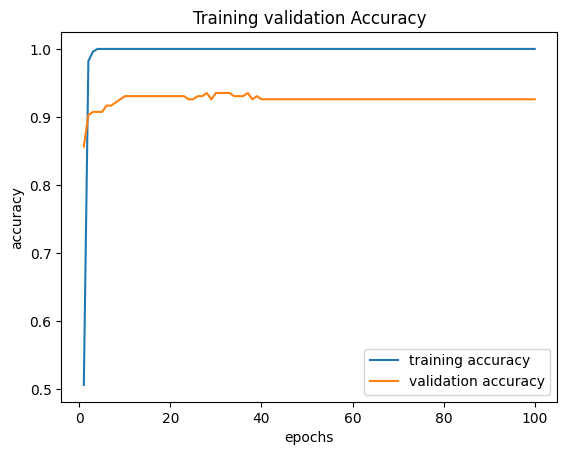

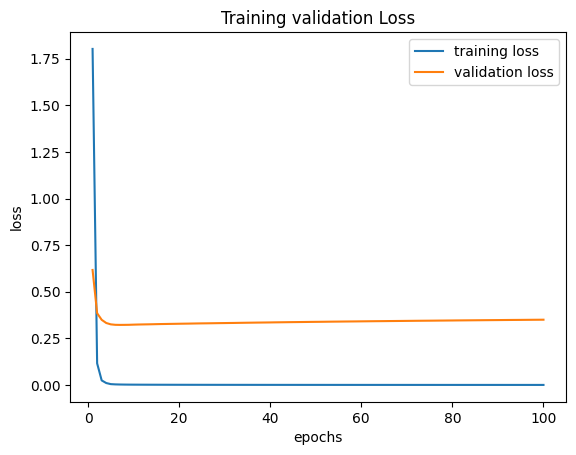

In [35]:
# Build and train the classification model
classification_model = build_and_train_model(visual_features, texture_features, labels)
classification_model

In [36]:
# save model and architecture to single file
classification_model.save("model_h5.h5")
print("Saved model to disk")

Saved model to disk


# Classification Report with Autoencoder

In [37]:
# lib's
import glob

In [38]:
# Load models
classification_model = load_model('model_h5.h5')
min_max_scaler_model = load(open('min_max_scaler_h5.pkl', 'rb'))
class_labels = ['bear', 'blue_whale', 'bobcat', 'cow', 'dolphin', 'gorilla', 
                'killer_whale', 'lion', 'monkey', 'mouse', 'ox', 'rabbit', 
                'rhinoceros', 'siamese_cat', 'skunk', 'squirrel', 'tiger', 'walrus']

In [89]:
def find_similar_sentences(target_sentence_index, sentence_to_latent, top_n=10):
    target_latent = sentence_to_latent[target_sentence_index]
    similarities = []
    for index, latent in sentence_to_latent.items():
        if index != target_sentence_index:
            similarity = 1 - cosine(target_latent, latent)
            similarities.append((index, similarity))
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

def predict_with_autoencoder(input_word_index, sentence_to_latent, top_n=5):
    # Find sentences similar to the first sentence
    similar_sentences = find_similar_sentences(input_word_index, sentence_to_latent, top_n=top_n)
    similar_words = [custom_sentences[index] for index, score in similar_sentences]
    return similar_words

In [93]:
'''
Note : Added way to read the folde images one by one.
'''

folder_name = 'cow'
folder_path = os.path.join('..', 'Dataset', 'artefact1', 'test', folder_name, '*')
print(folder_path)
for img_path in glob.glob(folder_path):
    print(img_path)
print('-'*30)

image_path, image_label, pred_image_label, act_label, pred_label, similar_words = [], [], [], [], [], []

# for img_path in glob.glob(r"test/*/*"):
for img_path in glob.glob(folder_path):
#     print(f"img_path : {img_path}")
    image_path.append(img_path)
    image_label.append(img_path.split('\\')[-2])
    act_label.append(class_labels.index(img_path.split('\\')[-2]))

    # Extract visual features using ResNet50
    visual_features = extract_visual_features(img_path)
#     print(f"visual_features : {visual_features.shape} || {type(visual_features)}")

    # Compute texture features using GLCM
    texture_features = compute_texture_features(img_path)
#     print(f"texture_feat : {texture_features.shape} || {type(texture_features)}")
    
    # Concatenate visual and texture features
    l1 = visual_features[0].tolist()
    l2 = texture_features.tolist()
    l1.extend(l2)
    combined_features = np.array(l1)
#     print(f"combined_features : {combined_features}")
    
    # Normalize the features
    train_normalized_texture_features = min_max_scaler_model.transform([combined_features])
    train_normalized_texture_features_df = pd.DataFrame(train_normalized_texture_features)
#     print(f"train_normalized_texture_features_df : {train_normalized_texture_features_df}")

#     model.predict
    predicted_value = classification_model.predict(train_normalized_texture_features_df, verbose = 0)
#     print(f"predicted_value : {np.argmax(predicted_value)} || {class_labels[np.argmax(predicted_value)]}")
    pred_image_label.append(class_labels[np.argmax(predicted_value)])
    pred_label.append(np.argmax(predicted_value))
    
#     print(f"class_labels[np.argmax(predicted_value)] : {class_labels[np.argmax(predicted_value)]}")
#     print(f"custom_sentences : {custom_sentences}")
#     print(f"custom_sentences.index('{class_labels[np.argmax(predicted_value)]}') : {custom_sentences.index(class_labels[np.argmax(predicted_value)])}")
#     custom_sentences.index('cat')
    
    similar_words_autoencoder = predict_with_autoencoder(custom_sentences.index(class_labels[np.argmax(predicted_value)]), 
                                                         sentence_to_latent, top_n=5) # class_labels
#     print(f"similar_words_autoencoder : {similar_words_autoencoder}")
    similar_words.append(similar_words_autoencoder)
    
#     break

print('-'*50)
out_df = pd.DataFrame({
    'image_path' : image_path, 
    'class_name' : image_label, 
    'pred_image_label' : pred_image_label, 
    'act_label' : act_label, 
    'pred_label' : pred_label,
    'similar_words' : similar_words
})
display(out_df.head())
print('-'*70)

metadata_folder_name =  os.path.join('..', 'Dataset', 'artefact1', 'csv', 'metadata')
os.makedirs(metadata_folder_name, exist_ok=True) 
metadata_file_name = os.path.join(metadata_folder_name, folder_name + '_resnet50_result.csv')
out_df.to_csv(metadata_file_name, index = False)
print(f"{metadata_file_name} : File saved.")
print('-'*100)

..\Dataset\artefact1\test\cow\*
..\Dataset\artefact1\test\cow\cow_10090.jpg
..\Dataset\artefact1\test\cow\cow_10091.jpg
..\Dataset\artefact1\test\cow\cow_10092.jpg
..\Dataset\artefact1\test\cow\cow_10093.jpg
..\Dataset\artefact1\test\cow\cow_10094.jpg
..\Dataset\artefact1\test\cow\cow_10095.jpg
..\Dataset\artefact1\test\cow\cow_10096.jpg
..\Dataset\artefact1\test\cow\cow_10097.jpg
------------------------------


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

--------------------------------------------------


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo

image_path class_name pred_image_label  \
0  ..\Dataset\artefact1\test\cow\cow_10090.jpg        cow               ox   
1  ..\Dataset\artefact1\test\cow\cow_10091.jpg        cow              cow   
2  ..\Dataset\artefact1\test\cow\cow_10092.jpg        cow              cow   
3  ..\Dataset\artefact1\test\cow\cow_10093.jpg        cow              cow   
4  ..\Dataset\artefact1\test\cow\cow_10094.jpg        cow              cow   

   act_label  pred_label                       similar_words  
0          3          10  [bull, goat, rabbit, sheep, horse]  
1          3           3  [goat, sheep, horse, bull, rabbit]  
2          3           3  [goat, sheep, horse, bull, rabbit]  
3          3           3  [goat, sheep, horse, bull, rabbit]  
4          3           3  [goat, sheep, horse, bull, rabbit]

----------------------------------------------------------------------
..\Dataset\artefact1\csv\metadata\cow_resnet50_result.csv : File saved.
----------------------------------------------------------------------------------------------------


In [67]:
'''
Note : Run only after compliting all classes
'''
metadata_file_name = os.path.join(metadata_folder_name, '*')
df_list = [pd.read_csv(df_path) for df_path in glob.glob(metadata_file_name)]

out_df = pd.concat(df_list).reset_index(drop=True)
display(out_df.head(10))

image_path image_label  \
0  ..\Dataset\artefact1\test\bear\bear_10001 (89)...        bear   
1  ..\Dataset\artefact1\test\bear\bear_10001 (90)...        bear   
2  ..\Dataset\artefact1\test\bear\bear_10001 (91)...        bear   
3  ..\Dataset\artefact1\test\bear\bear_10001 (92)...        bear   
4  ..\Dataset\artefact1\test\bear\bear_10001 (93)...        bear   
5  ..\Dataset\artefact1\test\bear\bear_10001 (94)...        bear   
6  ..\Dataset\artefact1\test\bear\bear_10001 (95)...        bear   
7  ..\Dataset\artefact1\test\bear\bear_10001 (96)...        bear   
8  ..\Dataset\artefact1\test\blue_whale\blue+whal...  blue_whale   
9  ..\Dataset\artefact1\test\blue_whale\blue+whal...  blue_whale   

  pred_image_label  act_label  pred_label  
0             bear          0           0  
1             bear          0           0  
2             bear          0           0  
3             bear          0           0  
4             bear          0           0  
5             bear          0           0  
6             bear          0           0  
7             bear          0           0  
8       blue_whale          1           1  
9       blue_whale          1           1

In [68]:
out_df

image_path image_label  \
0    ..\Dataset\artefact1\test\bear\bear_10001 (89)...        bear   
1    ..\Dataset\artefact1\test\bear\bear_10001 (90)...        bear   
2    ..\Dataset\artefact1\test\bear\bear_10001 (91)...        bear   
3    ..\Dataset\artefact1\test\bear\bear_10001 (92)...        bear   
4    ..\Dataset\artefact1\test\bear\bear_10001 (93)...        bear   
..                                                 ...         ...   
139  ..\Dataset\artefact1\test\walrus\walrus_10185.jpg      walrus   
140  ..\Dataset\artefact1\test\walrus\walrus_10186.jpg      walrus   
141  ..\Dataset\artefact1\test\walrus\walrus_10187.jpg      walrus   
142  ..\Dataset\artefact1\test\walrus\walrus_10188.jpg      walrus   
143  ..\Dataset\artefact1\test\walrus\walrus_10189.jpg      walrus   

    pred_image_label  act_label  pred_label  
0               bear          0           0  
1               bear          0           0  
2               bear          0           0  
3               bear          0           0  
4               bear          0           0  
..               ...        ...         ...  
139           walrus         17          17  
140           walrus         17          17  
141           walrus         17          17  
142           walrus         17          17  
143           walrus         17          17  

[144 rows x 5 columns]

[[8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 7 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 6 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 6 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8]] 

Accuracy: 0.958333 

Error rate: 0.041667 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      0.88 

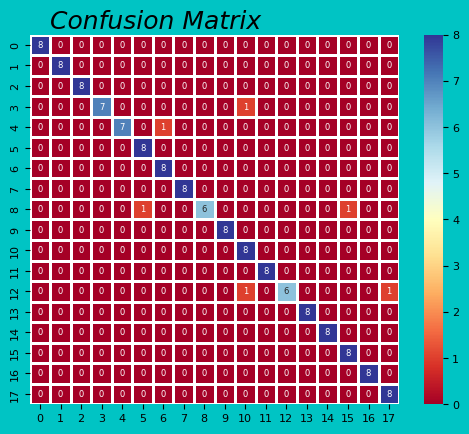

In [69]:
# confusion matrix
from sklearn.metrics import confusion_matrix
# accuracy: (tp + tn) / (p + n)
from sklearn.metrics import accuracy_score
# classification_report
from sklearn.metrics import classification_report
# kappa
from sklearn.metrics import cohen_kappa_score


true_labels = out_df['act_label']
predicted_labels = out_df['pred_label']

matrix = confusion_matrix(true_labels, predicted_labels)
print(matrix, '\n')

accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy: %f' % accuracy, '\n')
print('Error rate: %f' % (1-accuracy), '\n')

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report, '\n')

kappa = cohen_kappa_score(true_labels, predicted_labels)
print('Cohens kappa: %f' % kappa)



# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams['font.size'] = 8
bg_color = (0, 0.77, 0.77)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color

fig, ax = plt.subplots(1)

plt.text(1, -.3, "Confusion Matrix", fontsize = 18, color='Black', fontstyle='italic')

ax = sns.heatmap(matrix, annot=True, annot_kws={'size':6}, fmt="d",
                 robust=True, linewidths=.9, cmap="RdYlBu", square=True)
# vmin=0, vmax=350,
plt.savefig("Confusion_Matrix.jpeg", dpi=300, facecolor=bg_color, transparent=True)
plt.show()